## **Task 3**

Per i dati di test identificati come contaminazione da bolle (Anomaly), determina la posizione della bolla tra otto possibili posizioni: BV1 e da BP1 a BP7.

### **1. Importazione e preprocessing dei dati**

Importazione del dataset etichettato

In [2]:
import os
import pandas as pd

path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "train_data_aggregated_split.pkl")
df_train_aggregated= pd.read_pickle(file_path)

df_train_aggregated


,Spacecraft,Condition,SV1,SV2,SV3,SV4,BP1,BP2,BP3,BP4,...,P7_time_line_integral,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Window_ID
0,1,Normal,100,100,100,100,No,No,No,No,...,784.906580,0.017144,5.013518,5020.028779,65.000000,26930.154869,501.116403,11.633031,1,1
1,1,Normal,100,100,100,100,No,No,No,No,...,787.373792,-0.002641,5.016796,5610.686996,65.000000,26048.487157,508.501184,11.441019,1,2
2,1,Normal,100,100,100,100,No,No,No,No,...,789.525599,-0.003006,5.017115,5325.708422,64.837905,26122.284330,501.853078,11.428535,1,3
3,1,Normal,100,100,100,100,No,No,No,No,...,785.214600,-0.002262,4.994830,5071.356039,65.000000,27028.792007,505.424186,11.654316,2,1
4,1,Normal,100,100,100,100,No,No,No,No,...,787.175441,-0.003732,4.999298,5609.065086,65.000000,26860.719421,520.657365,11.618024,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,3,Anomaly,100,100,100,100,No,No,No,No,...,788.615572,0.266961,4.746968,5627.621157,60.000000,27846.049411,497.483160,11.829197,176,2
527,3,Anomaly,100,100,100,100,No,No,No,No,...,790.625595,0.267047,4.747359,5802.848670,59.850374,27917.903116,501.884458,11.814801,176,3
528,3,Anomaly,100,100,100,100,No,No,No,No,...,783.706148,0.008564,5.130090,3916.468924,65.000000,28643.386501,414.984117,11.997359,177,1
529,3,Anomaly,100,100,100,100,No,No,No,No,...,785.382561,-0.003840,5.136178,4246.767660,65.000000,28181.779625,418.906796,11.900293,177,2


Filtriamo solo le righe dove `Condition` è uguale ad Anomaly

In [ ]:
df_train_aggregated = df_train_aggregated[df_train_aggregated['Condition'] == 'Anomaly'].copy()

Creazione e popolamento della colonna `anomaly_location` con la posizione dell'anomalia

In [8]:
# Dizionario per mappare i sensori sulle classi numeriche
column_to_number = {'BP1': 1, 'BP2': 2, 'BP3': 3, 'BP4': 4, 'BP5': 5, 'BP6': 6, 'BP7': 7, 'BV1': 8}

# Creazione della colonna target
df_train_aggregated['anomaly_location'] = 0

# Popolamento della colonna target
for index, row in df_train_aggregated.iterrows():
    for col in column_to_number.keys():
        if row[col] == 'Yes':  # Se il sensore rileva un'anomalia
            df_train_aggregated.at[index, 'anomaly_location'] = column_to_number[col]
            break  # Assegna la prima anomalia trovata e interrompi il ciclo


df_train_aggregated[['Condition', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1', 'anomaly_location']].head(5)

,Condition,BP1,BP2,BP3,BP4,BP5,BP6,BP7,BV1,anomaly_location
459,Anomaly,Yes,No,No,No,No,No,No,No,1
460,Anomaly,Yes,No,No,No,No,No,No,No,1
461,Anomaly,Yes,No,No,No,No,No,No,No,1
462,Anomaly,No,Yes,No,No,No,No,No,No,2
463,Anomaly,No,Yes,No,No,No,No,No,No,2


Distribuzione delle 8 classi di `anomaly_condition`

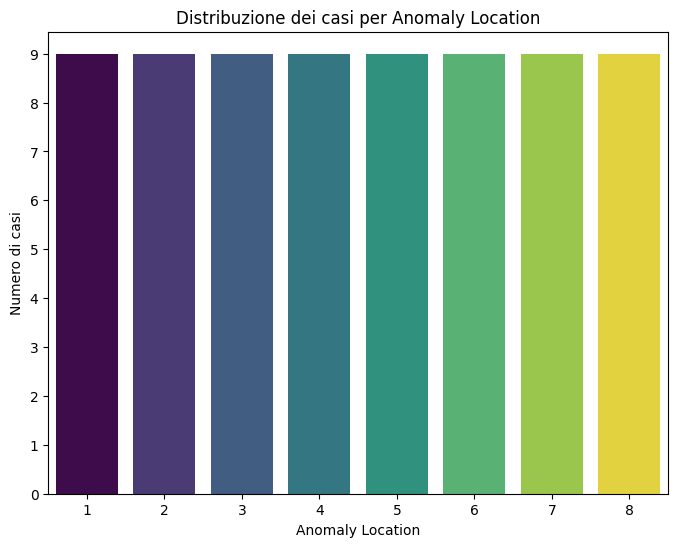

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

plt.figure(figsize=(8,6))
ax = sns.countplot(x='anomaly_location', data=df_train_aggregated, hue='anomaly_location', palette='viridis', dodge=False)
ax.legend_.remove()  # Rimuove la legenda perché hue è uguale a x
plt.xlabel("Anomaly Location")
plt.ylabel("Numero di casi")
plt.title("Distribuzione dei casi per Anomaly Location")
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Assicura tick interi sull'asse y
plt.show()

### **2. Selezione delle migliori feature con il metodo ANOVA F-Value**

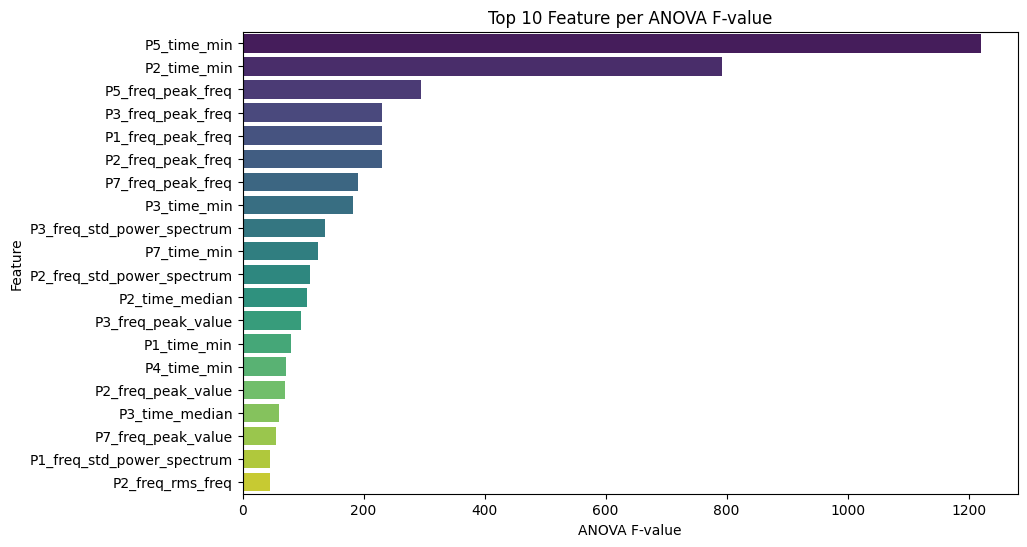

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, SelectKBest

# Separazione delle feature dal target
X = df_train_aggregated.drop(columns=['Spacecraft','BP1','BP2','BP3','BP4','BP5','BP6', 
                                      'BP7', 'BV1','SV1','SV2','SV3','SV4','anomaly_location', 'Condition', 'Case', "Window_ID"]) 
y = df_train_aggregated['anomaly_location']

# Calcolo gli F-value e i p-value per ogni feature
f_values, p_values = f_classif(X, y)

# Creo un DataFrame che riassume i risultati
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F_value': f_values,
    'p_value': p_values
}).sort_values(by='F_value', ascending=False)

top_10 = feature_scores.head(20)

# Feature con punteggio F-value più alto
plt.figure(figsize=(10, 6))
sns.barplot(x='F_value', y='Feature', data=top_10, hue='Feature', palette='viridis', dodge=False)
plt.xlabel("ANOVA F-value")
plt.ylabel("Feature")
plt.title("Top 10 Feature per ANOVA F-value")
plt.show()

Scegliamo le TOP N feature

In [12]:
selector = SelectKBest(score_func=f_classif, k=10) 
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print(selected_features)

Index(['P1_freq_peak_freq', 'P2_time_min', 'P2_freq_peak_freq', 'P3_time_min',
       'P3_freq_peak_freq', 'P3_freq_std_power_spectrum', 'P5_time_min',
       'P5_freq_peak_freq', 'P7_time_min', 'P7_freq_peak_freq'],
      dtype='object')


### **3. Addestramento del classificatore con Random Forest**

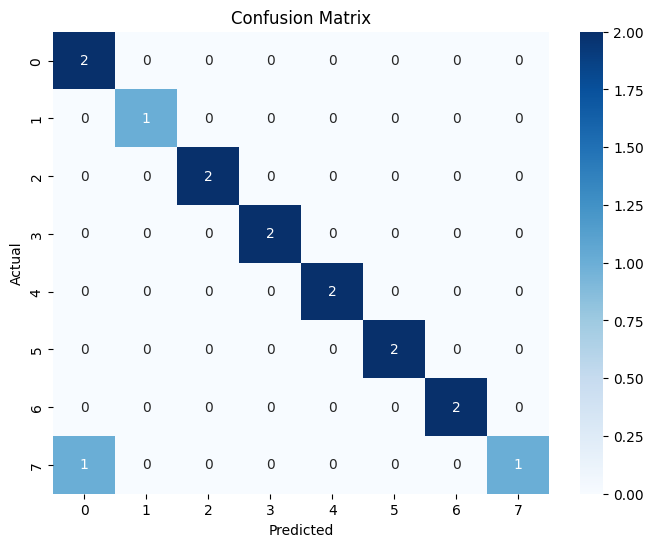

Classification Report:
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2

    accuracy                           0.93        15
   macro avg       0.96      0.94      0.93        15
weighted avg       0.96      0.93      0.93        15

Accuracy: 0.9333333333333333


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prendiamo le feature scelte con il metodo ANOVA F-Value 
X = X[selected_features]

# 2. Suddivisione in training e test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Addestramento del modello Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 4. Predizione sul test set
y_pred = rf_model.predict(X_test)

# 5. Calcolo e visualizzazione della matrice di confusione
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 6. Stampa delle metriche di valutazione
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Salvo il modello in `anomaly_locations.pkl`

In [17]:
import pickle

with open("anomaly_locations.pkl", "wb") as f:
    pickle.dump(rf_model, f)


### **4. Predizioni sul test set non etichettato e confronto finale con il ground truth**

In [36]:
path_dataframes = os.path.join("..", "dataset", "dataframes")
file_path = os.path.join(path_dataframes, "test_aggregated_split_with_condition.pkl")
test_data_aggregated_split= pd.read_pickle(file_path)

test_data_aggregated_split.head(5)

,Spacecraft,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,...,P7_time_min,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Window_ID,Condition
0,1,1.984074,1.968528,1.897964,2.057444,0.089958,791.609870,0.599879,4.409431,1187.765081,...,-0.001597,4.957685,3639.567068,62.50000,25240.991187,404.252030,11.262289,178,1,2
1,1,1.984509,1.963438,1.898697,2.057745,0.090624,791.774258,0.561861,4.411653,1202.301221,...,-0.003549,4.959830,3945.055858,62.50000,23656.785685,391.929474,10.903133,178,2,2
2,1,1.984681,1.963766,1.899070,2.057667,0.090409,793.837928,0.561754,4.411926,1228.619720,...,-0.003637,4.960276,3979.709606,62.34414,23695.311811,390.011746,10.884694,178,3,2
3,1,1.984472,1.960340,1.892148,2.062852,0.093266,791.761654,0.479821,4.100935,1256.382067,...,0.054438,5.082534,4950.370311,65.00000,27089.997640,499.897599,11.667504,179,1,3
4,1,1.985048,1.958879,1.894102,2.063106,0.093737,791.969210,0.453900,4.103057,1253.972941,...,-0.002586,5.085373,5538.603524,65.00000,25996.746576,504.627198,11.429651,179,2,3


Filtriamo solo le righe dove `Condition` è uguale ad Anomaly

In [ ]:
df_test_split = test_data_aggregated_split[test_data_aggregated_split['Condition'] == 2].copy()

In [ ]:
# Predizioni riga per riga usando solo le feature selezionate
X_test_pred = df_test_split[selected_features]
y_pred_rows = rf_model.predict(X_test_pred) 

In [24]:
# Aggiungiamo la colonna "anomaly_location" al DataFrame
df_test_split = df_test_split.copy()  # per evitare SettingWithCopyWarning
df_test_split.loc[:, 'anomaly_location'] = y_pred_rows

Majority Voting per ottenere una predizione univoca per ogni Case

In [ ]:
df_case_predictions = df_test_split.groupby("Case")["anomaly_location"] \
    .agg(lambda x: x.value_counts().idxmax()).reset_index()

Uniamo con il ground truth preso da `answer_competition.csv`

In [31]:
# Importo il file 
df_answer = pd.read_csv("../dataset/test/answer_competition.csv")

# Eseguo il merge tra df_case_predictions (predizioni) e df_answer (ground truth)
df_compare = pd.merge(df_case_predictions, df_answer[['ID', 'task3']], left_on='Case', right_on='ID', how='inner')
df_compare.rename(columns={'anomaly_location': 'Predicted', 'task3': 'Expected'}, inplace=True)
df_compare[['Case', 'Predicted', 'Expected']]

,Case,Predicted,Expected
0,178,2,2
1,186,6,6
2,193,1,1
3,196,4,4
4,197,7,7
5,209,7,7
6,216,1,1
7,219,5,5
8,221,2,2


Visualizziamo la matrice di confusione

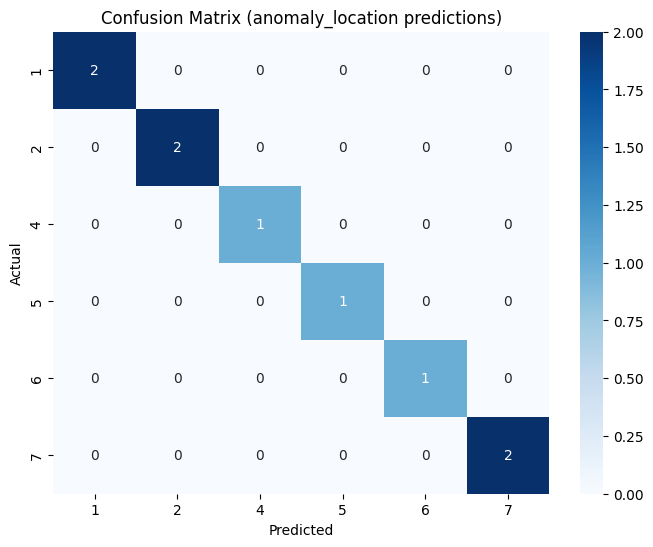

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Accuracy: 1.0


In [32]:

classes = sorted(df_compare["Expected"].unique())
cm = confusion_matrix(df_compare["Expected"], df_compare["Predicted"], labels=classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (anomaly_location predictions)")
plt.show()

print("Classification Report:")
print(classification_report(df_compare["Expected"], df_compare["Predicted"]))
print("Accuracy:", accuracy_score(df_compare["Expected"], df_compare["Predicted"]))

### **5. Aggiunta della colonna `anomaly_location` al test set** (con le predizioni del Task 3)

In [47]:
# Eseguiamo il merge in modo che per ogni riga di df_test_aggregated_split venga aggiunta 
# la colonna "anomaly_locations" presa da df_case_predictions, basandoci sul campo "Case".
# Se un caso in df_test_aggregated_split non ha corrispondenza in df_case_predictions, il valore verrà NaN.
df_test_final = pd.merge(test_data_aggregated_split, 
                         df_case_predictions[['Case', 'anomaly_location']], 
                         on='Case', 
                         how='left')

df_test_final['anomaly_location'] = df_test_final['anomaly_location'].fillna(0).astype(int)
df_test_final.head(10)

,Spacecraft,P1_time_mean,P1_time_median,P1_time_p25,P1_time_p75,P1_time_variance,P1_time_line_integral,P1_time_min,P1_time_max,P1_freq_peak_value,...,P7_time_max,P7_freq_peak_value,P7_freq_peak_freq,P7_freq_sum_power_spectrum,P7_freq_std_power_spectrum,P7_freq_rms_freq,Case,Window_ID,Condition,anomaly_location
0,1,1.984074,1.968528,1.897964,2.057444,0.089958,791.609870,0.599879,4.409431,1187.765081,...,4.957685,3639.567068,62.500000,25240.991187,404.252030,11.262289,178,1,2,2
1,1,1.984509,1.963438,1.898697,2.057745,0.090624,791.774258,0.561861,4.411653,1202.301221,...,4.959830,3945.055858,62.500000,23656.785685,391.929474,10.903133,178,2,2,2
2,1,1.984681,1.963766,1.899070,2.057667,0.090409,793.837928,0.561754,4.411926,1228.619720,...,4.960276,3979.709606,62.344140,23695.311811,390.011746,10.884694,178,3,2,2
3,1,1.984472,1.960340,1.892148,2.062852,0.093266,791.761654,0.479821,4.100935,1256.382067,...,5.082534,4950.370311,65.000000,27089.997640,499.897599,11.667504,179,1,3,0
4,1,1.985048,1.958879,1.894102,2.063106,0.093737,791.969210,0.453900,4.103057,1253.972941,...,5.085373,5538.603524,65.000000,25996.746576,504.627198,11.429651,179,2,3,0
5,1,1.985274,1.959431,1.894454,2.062764,0.093530,794.048758,0.453799,4.103312,1196.854862,...,5.085864,5266.783208,64.837905,26062.265816,498.435789,11.415399,179,3,3,0
6,1,1.984440,1.961368,1.892301,2.058812,0.094869,791.748228,0.462211,4.260331,1265.484030,...,4.997548,4825.578371,65.000000,26225.137975,480.246829,11.479748,180,1,0,0
7,1,1.985128,1.958562,1.893963,2.059024,0.095242,791.999675,0.436941,4.262515,1267.293923,...,5.001972,4758.036912,65.000000,27288.839543,465.545005,11.710245,180,2,0,0
8,1,1.985348,1.959714,1.894225,2.058572,0.095028,794.076633,0.436712,4.262760,1208.996609,...,5.000872,4807.319495,64.837905,26487.770659,475.790313,11.508208,180,3,0,0
9,1,1.984485,1.959423,1.892123,2.059063,0.094856,791.766312,0.468537,4.276943,1265.232117,...,4.990073,4923.349350,65.000000,26207.816478,487.507119,11.475956,181,1,3,0


In [43]:
# Esporta il DataFrame finale in CSV e Pickle
df_test_final.to_csv('../dataset/dataframes/test_data_split_with_condition_and_anomaly_location.csv', index=False)
df_test_final.to_pickle('../dataset/dataframes/test_data_split_with_condition_and_anomaly_location.pkl')